# Introduction

This tutorial will walk you through how to download a spatial and variable subset of data.  If you are only interested in a small region of a certain dataset, it is not necessary to downlaod the entire dataset to your local machine. For example, downloading one full orbit of Orbiting Carbon Observatory 2 (OCO-2) Level 1B data from the GES DISC can take several minutes, while downloading a granule of the data takes a matter of seconds. You can learn more about the OCO-2 mission [here](https://oco.jpl.nasa.gov/science/).

# Import Dependencies
Let's import all the libraries we need. This needs to be done before any of the other cells can be run. These libraries were installed in the docker container you are using, so we will not need to worry about installing anything. Simply running the following cell takes care of all of the dependencies.

In [31]:
from mpl_toolkits.basemap import Basemap
from pydap.cas.urs import setup_session
from pydap.client import open_url
import numpy as np
import netCDF4
import getpass

## Procedure

We will identify granules in data by looking at the latitude and longitude cooridantes for regions of interest.  In this tutorial, we are interested in extracting a subset of OCO-2 Level 1B radiances within a 5x5 degree box centered at the Mauna Loa volcano in Hawaii.

## Finding the Data Set

We can find the appropriate dataset by using DAAC search engines such as OpenSearch or by navigating OPenNDAP directories of datasets. Let's go through these two methods.

### Navigating OPeNDAP Directories
Open-source Project for a Network Data Access Protocol, or OPeNDAP, is a protocol for accessing Earth science data.  Let's start by going to an OPeNDAP server.

1. Go to the following URL: https://oco2.gesdisc.eosdis.nasa.gov/opendap/hyrax/

2. Open the directory: `OCO2_L1B_Science.7r/`

3. Open the directory: `2015/`

4. Open the directory: `015/`

5. Click on the last file: `oco2_L1bScND_02879a_150115_B7000r_150616093751.h5`

You are now on an *OpenNDAP Server Dataset Access Form*. From here, you can see the global attriubutes and the variables for this dataset.  Feel free to skim this page to get an idea of what sort of data is contained within OCO-2 Level 1B data. If you wish (*not part of this tutorial*), you can download the entire data set as a NetCDF-4 File (in the *Action* row).

### Using OpenSearch to Obtain Subset of Data

Instead of using an OPeNDAP Server Dataset Access Form as shown above, let's use a DAAC search engine to find this same data set. Let's suppose we want granules from 09/01/2014 to 08/31/2015 that have observations near a 5x5 degree of Mauna Loa. A quick search on Google Maps shows that Mauna Loa is located at [-155.590951, 19.472847](https://www.google.com/maps/place/Mauna+Loa/@19.4721389,-155.5943953,17z/data=!3m1!4b1!4m5!3m4!1s0x7953e45a9a2e3483:0x21188532375f4e6b!8m2!3d19.4721389!4d-155.5922066) (longitude, latitude).  We can use OpenSearch to find granules given the spatial and temporal criteria.  We will use the *wget* command to download a list of URLs which we can access data granules from.

First, let's make sure we are in the right directory.  We want to create this text file in the same directory as this Jupyter Notebook. In your terminal, type in the following command:

> `cd /home/condauser/tutorials/notebooks/SUBSET_TUTORIAL`
<br>

Now, let's list the contents of the directory. Run the following command:

>`ls`
<br>

Currently, there should be no existing .txt file.  Now, we will use the `wget`, `grep`, and `egrep` commands to obtain these URLs from the OpenSearch. In your terminal, run the follwoing command:
<br>

>`wget -q "http://mirador.gsfc.nasa.gov/cgi-bin/mirador/granlist.pl?searchType=Nominal&format=atom&startTime=2014-09-01T00:00:00Z&endTime=2015-08-31T00:00:00Z&osLocation=-158.09,16.97,-153.09,22.07&maxgranules=10000&dataSet=OCO2_L1B_Science.7r" -O - | grep 'OPeNDAP HTML' | egrep -o 'href=\".*h5.html\"' | egrep -o 'http.*html' > URLs.txt`


Notice that the *wget* URL contains all of the search criteria we desired:

* startTime=2014-09-01
* endTime=2015-08-31
* Location=-158.09,16.97,-153.09,22.07
* dataSet=OCO2_L1B_Science.7r

The command also contains GNU three programs that allow us to obtain and parse the correct information.

* *wget*: Retrieve a file from the world wide web
* *grep*: Pattern matching command, in this case for any line containing 'OPeNDAP HTML'
* *egrep*: Extention of grep, in this case pattern matching for any line starting with 'http' and ending with 'html'

Notice that the output of *wget* is piped by use of `|` to grep/egrep.  The output of grep/egrep is redirected to URLs.txt by use of `>`.

You now have a file (URLs.txt) containing all of the URLs that contain the right granules of the data set. You can see this by running the following command in your terminal:
>`ls`

## Hierarchical Data Format
Let's print out all the URLs this command captured. We will leave out the last 5 characters (.html).

In [2]:
for line in open("URLs.txt", "r").readlines():
    print(line[:-6])

https://oco2.gesdisc.eosdis.nasa.gov/opendap/OCO2_L1B_Science.7r/2014/252/oco2_L1bScGL_01015a_140909_B7000r_150603124338.h5
https://oco2.gesdisc.eosdis.nasa.gov/opendap/OCO2_L1B_Science.7r/2014/254/oco2_L1bScGL_01044a_140911_B7000r_150603233021.h5
https://oco2.gesdisc.eosdis.nasa.gov/opendap/OCO2_L1B_Science.7r/2014/256/oco2_L1bScGL_01073a_140913_B7000r_150604051650.h5
https://oco2.gesdisc.eosdis.nasa.gov/opendap/OCO2_L1B_Science.7r/2014/261/oco2_L1bScGL_01146a_140918_B7000r_150605173100.h5
https://oco2.gesdisc.eosdis.nasa.gov/opendap/OCO2_L1B_Science.7r/2014/263/oco2_L1bScGL_01175a_140920_B7000r_150606035458.h5
https://oco2.gesdisc.eosdis.nasa.gov/opendap/OCO2_L1B_Science.7r/2014/265/oco2_L1bScGL_01204a_140922_B7000r_150606061714.h5
https://oco2.gesdisc.eosdis.nasa.gov/opendap/OCO2_L1B_Science.7r/2014/268/oco2_L1bScND_01248a_140925_B7000r_150606134456.h5
https://oco2.gesdisc.eosdis.nasa.gov/opendap/OCO2_L1B_Science.7r/2014/270/oco2_L1bScND_01277a_140927_B7000r_150606204617.h5
https://

Each of these URLs is a .h5 file (Hierarchical Data Format 5) that contains the pertinent granules of data for the OCO-2 Level1B dataset.

### Using OPeNDAP URL Suffixes

Adding ".html" to any of these URLs will take you to the OPeNDAP Data Access Form for that granule. You can download the data from here (not part of this tutorial).

Adding ".ddx", ".ddx", ".das", ".info", and ".rdf" returns the metadata for that granule. ".info" is the most useful in a web browser.

Adding ".ascii", ".nc", ".nc4", ".dods" will download the files (to your machine) in various formats such as netCDF-4.

Feel free to add ".html" or ".info" to get a feel for the suffixes.

## Reading Spatial Subsets into Python
Now that we've gone through the exercise of locating datasets, let's import data directly from a server into the Jupyter Notebook.  We are giong to make use of the *pydap* package.

### Using Pydap

Let's use the following URL. It is one of the URLs from `URLs.txt`.

https://oco2.gesdisc.eosdis.nasa.gov/opendap/hyrax/OCO2_L1B_Science.7r/2015/015/oco2_L1bScND_02879a_150115_B7000r_150616093751.h5

Add ".html" to the end of the URL and navigate to that website. You will notice the following variables:

1. _SoundingGeometry_sounding_latitude
2. _SoundingGeometry_sounding_longitude
3. _SoundingMeasurements_radiance_weak_co2

In [4]:
opendap_url = r'https://oco2.gesdisc.eosdis.nasa.gov/opendap/hyrax/OCO2_L1B_Science.7r/2015/015/oco2_L1bScND_02879a_150115_B7000r_150616093751.h5'

The "r" in front of the string ensures the URL is read a *raw string literal* so that it ignores special characters (such as \t).

In [5]:
print(opendap_url)

https://oco2.gesdisc.eosdis.nasa.gov/opendap/hyrax/OCO2_L1B_Science.7r/2015/015/oco2_L1bScND_02879a_150115_B7000r_150616093751.h5


Let's use the pydap package to have access to the data set through the URL. Note that we do not need to download the data set in this case. To do this, we are going to need setup a pydap session that will allow us to access the .h5 URL. You're going to need your Earthdata credentials.  Running the next code block will prompt you to enter in your username.

In [6]:
username = input("input your username: ")

input your username: kvgarimella


The same applies for the next code block.

In [7]:
password = getpass.getpass()

········


Run the following cell. This will set up the a Pydap session where we can access the data from a URL instead of downloading it to your local machine.  It will also remove the *username* and *password* variables that have your Earthdata credentials.

In [8]:
session = setup_session(username=username, password=password, check_url=opendap_url)
username = ''
password = ''

Now, let's get the dataset.

In [9]:
dataset = open_url(opendap_url, session=session)

We can inspect this data set and see all of the variables and measurments.

In [10]:
dataset.children

<bound method StructureType.__iter__ of <DatasetType with children '_FootprintGeometry_footprint_altitude', '_FootprintGeometry_footprint_altitude_uncert', '_FootprintGeometry_footprint_aspect', '_FootprintGeometry_footprint_azimuth', '_FootprintGeometry_footprint_land_fraction', '_FootprintGeometry_footprint_latitude', '_FootprintGeometry_footprint_latitude_geoid', '_FootprintGeometry_footprint_longitude', '_FootprintGeometry_footprint_longitude_geoid', '_FootprintGeometry_footprint_o2_qual_flag', '_FootprintGeometry_footprint_plane_fit_quality', '_FootprintGeometry_footprint_polarization_angle', '_FootprintGeometry_footprint_slope', '_FootprintGeometry_footprint_solar_azimuth', '_FootprintGeometry_footprint_solar_zenith', '_FootprintGeometry_footprint_stokes_coefficients', '_FootprintGeometry_footprint_strong_co2_qual_flag', '_FootprintGeometry_footprint_surface_roughness', '_FootprintGeometry_footprint_time_string', '_FootprintGeometry_footprint_time_tai93', '_FootprintGeometry_foot

## Indexing Data based on a Bounded Region

Let's grab the latitude and longitude data we were working with earlier. We can store the attributes in variables by treating the dataset as a dictionary and inputing the variable names (as seen in the above attributes output) as keys to this dictionary. You will notice that these variable names are consistent with those seen on the OPeNDAP server. 

In [11]:
sounding_geometry_sounding_latitude = dataset["_SoundingGeometry_sounding_latitude"]
sounding_geometry_sounding_longitude = dataset["_SoundingGeometry_sounding_longitude"]

In [12]:
sounding_geometry_sounding_latitude.shape

(8364, 8)

The shape and size of the data is the same is also consistent with the OPeNDAP server.

These two variables, however, hold the entire longitude and latitude coordinates information.  Remember, we were interested in a 5x5 degree region around Mauna Loa the volcano (-155.59, 19.47). The region was given by the following coordinates:
* west: -158.09
* south: 16.97
* east: -153.09
* north: 22.07

In [13]:
west = -158.09
south = 16.97
east = -153.09
north = 22.07
region_of_interest = [west, south, east, north]

We can use the *numpy* function, *np.where*, to find the indices of data that match our region of interest.

In [14]:
indices_above_west_south, indices_below_east_north = np.where(  (sounding_geometry_sounding_longitude.data[:] > region_of_interest[0]) \
                                                              & (sounding_geometry_sounding_latitude.data[:] > region_of_interest[1])  \
                                                              & (sounding_geometry_sounding_longitude.data[:] < region_of_interest[2]) \
                                                              & (sounding_geometry_sounding_latitude.data[:] < region_of_interest[3]))

In [15]:
# Here's an example of how np.where works
a = np.asarray([1,2,3,4,5])
np.where(a > 3)

(array([3, 4]),)

In [16]:
indices_above_west_south

array([5992, 5992, 5992, ..., 6245, 6245, 6246])

In [17]:
indices_below_east_north

array([0, 1, 2, ..., 6, 7, 7])

Now, we have the indices that correspond to the data for each variable within a 5x5 degree of the volcano.

Now that we have the appropriate indices, let's first get the subset of latitude and longitude coordinates that correspond to this data. We'll create two variables that will be our ranges for indexing.

In [18]:
west_south_slice = slice(indices_above_west_south.min(), indices_above_west_south.max() + 1)
east_north_slice = slice(indices_below_east_north.min(), indices_below_east_north.max() + 1)

In [19]:
# Here's an example of how slices work in Python
example_list = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']
example_slice = slice(2,5)
print(example_list[example_slice])

['c', 'd', 'e']


Let's get the subsets of the latitude and longitude data.

In [20]:
latitude_subset = dataset["_SoundingGeometry_sounding_latitude"].data[west_south_slice, east_north_slice]
longitude_subset = dataset["_SoundingGeometry_sounding_longitude"].data[west_south_slice, east_north_slice]

Compare this subset of latitude data to the total latitude data.

In [21]:
print("Subset Latitude shape:", latitude_subset.shape)
print("Total Latitude shape :", sounding_geometry_sounding_latitude.shape)

Subset Latitude shape: (255, 8)
Total Latitude shape : (8364, 8)


It is clear that we have greatly reduced the amount of data we will need by focusing on the data in a 5x5 degree box around the volcano.

Now, let's get the subsets of the actual measurements we want. In this case, O2 Radiance, Strong CO2 Radiance, and Weak CO2 Radiance.  

In [22]:
radiance_O2_subset = dataset["_SoundingMeasurements_radiance_o2"].data[west_south_slice, east_north_slice]
radiance_strong_CO2_subset = dataset["_SoundingMeasurements_radiance_strong_co2"].data[west_south_slice, east_north_slice]
radiance_weak_CO2_subset = dataset["_SoundingMeasurements_radiance_weak_co2"].data[west_south_slice, east_north_slice]

In [23]:
radiance_O2_subset

array([[[  8.44491011e+18,   8.32489237e+18,   8.18422690e+18, ...,
           7.36158934e+18,   7.76452462e+18,   7.81480583e+18],
        [  8.17203936e+18,   8.38323245e+18,   8.16922571e+18, ...,
           7.12338839e+18,   7.66981378e+18,   7.92689390e+18],
        [  8.14079729e+18,   8.26092993e+18,   8.28451005e+18, ...,
           7.06443258e+18,   7.48516730e+18,   7.81499770e+18],
        ..., 
        [  8.13603585e+18,   8.30087903e+18,   8.40814299e+18, ...,
           7.15035281e+18,   7.28501880e+18,   7.45514953e+18],
        [  8.12478180e+18,   8.52851587e+18,   8.40987417e+18, ...,
           7.29269559e+18,   7.39354554e+18,   7.42334836e+18],
        [  7.79693657e+18,   8.20313740e+18,   8.11397525e+18, ...,
           7.14648363e+18,   7.10132229e+18,   7.17221715e+18]],

       [[  8.23881875e+18,   8.08472659e+18,   7.94476866e+18, ...,
           7.32419055e+18,   7.55421773e+18,   7.77553513e+18],
        [  8.12526668e+18,   8.07387881e+18,   8.16938844e+1

We have now succesfully obtained a subset of data from a server without having to download a large file.

In [24]:
radiance_O2_subset.shape

(255, 8, 1016)

## Plotting the Data

We will now use Basemap to plot some of the data. 

In [26]:
lat_min = np.min(latitude_subset)
lat_max = np.max(latitude_subset)
lon_min = np.min(longitude_subset)
lon_max = np.max(longitude_subset)
%matplotlib inline

The last line in the above box ensures that any plot will appear within the Jupyter Notebook.

In [27]:
lat_min, lon_min

(16.95529, -157.86559)

In [28]:
lat_max, lon_max

(22.088903, -156.61108)

/Users/Karthik/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3296: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/Karthik/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3305: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)
/Users/Karthik/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3342: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/Karthik/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3381: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


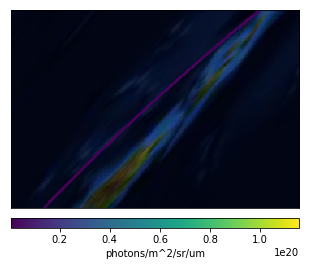

In [30]:
m = Basemap(llcrnrlon=lon_min, llcrnrlat=lat_min, urcrnrlon=lon_max, urcrnrlat=lat_max, resolution='l', projection='aeqd', lon_0=0, lat_0=0)


m.bluemarble()
pc = m.pcolor(longitude_subset, latitude_subset, radiance_weak_CO2_subset[:,:,0], latlon=True)
cbar = m.colorbar(pc, location="bottom", pad="5%")
cbar.set_label("photons/m^2/sr/um")

Now, we can see the data for the Weak CO2 Radiance move across the diagonal of the map projection.

## Constructing a URL for a Spatial Subset

Instead of reading in the spatial subset as shown above (Reading Spatial Subsets into Python) using the *pydap* package, we can construct a URL based on the indices that match data in a 5x5 degree region around Mauna Loa. Then, you can use this URL to download the granule directly to your local machine. From here, we can use the *netCDF4* package to plot the data.

We have already found the indices that match to the data over a 5x5 degree region around the volcano.

In [34]:
indices_above_west_south

array([5992, 5992, 5992, ..., 6245, 6245, 6246])

In [35]:
indices_below_east_north

array([0, 1, 2, ..., 6, 7, 7])

In [36]:
print(np.min(indices_above_west_south), np.max(indices_above_west_south))
print(np.min(indices_below_east_north), np.max(indices_below_east_north))

5992 6246
0 7


First, we will start with our original .h5 URL.

https://oco2.gesdisc.eosdis.nasa.gov/opendap/OCO2_L1B_Science.7r/2015/015/oco2_L1bScND_02879a_150115_B7000r_150616093751.h5

Next, we will append ".nc4?" and the subset of variables and indices we would like.

In [55]:
url = "https://oco2.gesdisc.eosdis.nasa.gov/opendap/OCO2_L1B_Science.7r/2015/015/oco2_L1bScND_02879a_150115_B7000r_150616093751.h5"

In [56]:
url = url + ".nc4?"

Now, we can add the variable name and the indeces that corresponds to the data above the volcano.

In [57]:
url = url + "_SoundingGeometry_sounding_latitude[5992:6246][0:7],"

In [58]:
url = url + "_SoundingGeometry_sounding_longitude[5992:6246][0:7],"

In [59]:
url = url + "_SoundingMeasurements_radiance_weak_co2[5992:6246][0:7][0:1015]"

Notice that the radiance measurment has a third dimension: `[0:1015]`. You can see this by examining the shape of the radiance variable.

In [60]:
radiance_weak_CO2_subset.shape

(255, 8, 1016)

In [61]:
print(url)

https://oco2.gesdisc.eosdis.nasa.gov/opendap/OCO2_L1B_Science.7r/2015/015/oco2_L1bScND_02879a_150115_B7000r_150616093751.h5.nc4?_SoundingGeometry_sounding_latitude[5992:6246][0:7],_SoundingGeometry_sounding_longitude[5992:6246][0:7],_SoundingMeasurements_radiance_weak_co2[5992:6246][0:7][0:1015]


If you click on the above URL, a .nc4 file will download directly to your machine.  Alternatively, we can use *wget* to obtain the data from the above URL.  You will need your Earthdata login info.  Run the following command in your terminal. *Make sure to put single quotes around your username and password to catch special characters*.

> wget --user=`'<username>'` --password=`'<password>'` -O subset.nc4  "https://oco2.gesdisc.eosdis.nasa.gov/opendap/OCO2_L1B_Science.7r/2015/015/oco2_L1bScND_02879a_150115_B7000r_150616093751.h5.nc4?_SoundingGeometry_sounding_latitude[5992:6246][0:7],_SoundingGeometry_sounding_longitude[5992:6246][0:7],_SoundingMeasurements_radiance_weak_co2[5992:6246][0:7][0:1015]"

Now, let's use *netCDF4* to examine this downloaded subset. Then, we will plot it.

In [62]:
data = netCDF4.Dataset("subset.nc4")

In [63]:
for v in data.variables:
    print(v)

_SoundingGeometry_sounding_latitude
_SoundingGeometry_sounding_longitude
_SoundingMeasurements_radiance_weak_co2


In [64]:
lat_nc4 = data["_SoundingGeometry_sounding_latitude"][:]
lon_nc4 = data["_SoundingGeometry_sounding_longitude"][:]
rad_nc4 = data["_SoundingMeasurements_radiance_weak_co2"][:]

In [65]:
lat_nc4.shape

(255, 8)

In [66]:
lon_nc4.shape

(255, 8)

You can see that the shape of the data from the downloaded `.nc4` file is the same as the shape of the data from the *pydap* server.

In [68]:
latitude_subset.shape

(255, 8)

In [70]:
rad_nc4.shape == radiance_weak_CO2_subset.shape

True

In [71]:
lats_min = lat_nc4.min()
lats_max = lat_nc4.max()
lons_min = lon_nc4.min()
lons_max = lon_nc4.max()

/Users/Karthik/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3296: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/Karthik/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3305: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)
/Users/Karthik/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3342: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/Karthik/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3381: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


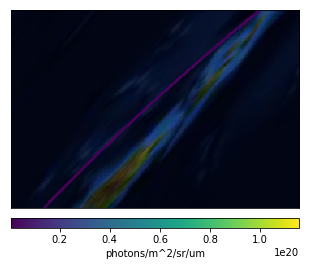

In [73]:
m = Basemap(llcrnrlon=lons_min, llcrnrlat=lats_min, urcrnrlon=lons_max, urcrnrlat=lats_max, resolution='l', projection='aeqd', lon_0=0, lat_0=0)


m.bluemarble()
pc = m.pcolor(lon_nc4, lat_nc4, rad_nc4[:,:,0], latlon=True)
cbar = m.colorbar(pc, location="bottom", pad="5%")
cbar.set_label("photons/m^2/sr/um")

You can see that the downloaded `.nc4` map agrees with the map produced by the data from the *pydap* server.